In [9]:
#pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd

np.random.seed(45)

# fetch dataset 
acute_inflammations = fetch_ucirepo(id=184) 
  
# data (as pandas dataframes) 
X = acute_inflammations.data.features 
y = acute_inflammations.data.targets 

data_combined = pd.concat([X, y], axis=1)

def replace_values(df):
    df = df.applymap(lambda x: str(x).replace(",", "."))
    df = df.applymap(lambda x: str(x).replace("\t", ","))
    df = df.applymap(lambda x: str(x).replace("yes", "1"))
    df = df.applymap(lambda x: str(x).replace("no", "0"))
    return df

# Apply the replacement function to the DataFrame
data_combined = replace_values(data_combined)

# Write the modified DataFrame to a CSV file
data_combined.to_csv("diagnosis.csv", index=False)



(Text(0.5, 0, 'x'), Text(0, 0.5, 'y'))

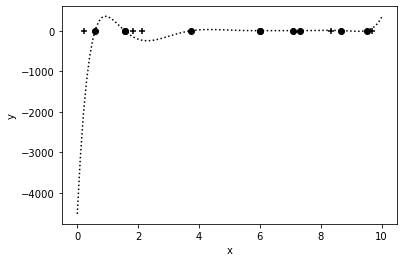

In [2]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

np.random.seed(42)

x = 10*np.random.rand(15)
y = x + 0.5 * np.random.rand(15)

p = interpolate.lagrange(x[0:10], y[0:10])
xp = np.linspace(0, 10, 100)
yp = p(xp)

plt.scatter(x[0:10], y[0:10], c = 'k')

plt.scatter(x[0:15], y[0:15], c = 'k', marker='+')
plt.plot(xp, yp, 'k:')
plt.xlabel('x'), plt.ylabel('y')

In [39]:
import numpy as np
fFloat = open("diagnosis.csv", "r")
header = fFloat.readline().rstrip('\n')
ColumnNames = header.split(',')
dataset = np.loadtxt(fFloat, delimiter=",")
X = dataset[:,1:6]
Y = dataset[:,6]

allData = np.arange(0, X.shape[0]) # how many rows

# int(X.shape[0]*0.2) determines the number of samples to draw, which is 20% of the total number of rows in X.
# ensures that the same index is not chosen more than once
iTesting = np.random.choice(X.shape[0], int(X.shape[0]*0.2), replace=False)
iTraining = np.delete(allData, iTesting)

dataRecords = len(iTraining)

XTraining = X[iTraining,:]
YTraining = Y[iTraining] 

print(YTraining)


## P(i|x) = P(x|i) * P(i) / (sum(P(x|j) * P(j)))
## vector x belongs to class i

## P(i|x) = mul(P(x_k|i) * P(i)) / (sum(mul(P(x_k|j)) * P(j)))

[0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


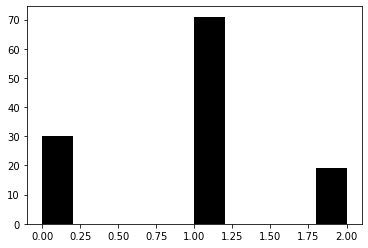


 30 - healthy people
 71 - one diagnosis
 19 - both diagnosis



In [25]:
diag = np.sum(dataset[:,6:8], axis=1)
plt.hist(diag, color='k')
plt.show()
print('\n',np.sum(diag == 0), '- healthy people\n', np.sum(diag == 1), '- one diagnosis\n', np.sum(diag == 2), '- both diagnosis\n')

In [47]:
import numpy as np
PXI = np.zeros((2, XTraining.shape[1], 2))
PI = np.zeros(2)
for k in range(XTraining.shape[1]):
    # a and b
    # P(x_k) with P(x_k = yes | i = 1)
    PXI[1, k, 1] = np.sum(np.logical_and(XTraining[:,k], YTraining))
    # not a and b
    # P(x_k) with P(x_k = no | i = 1)
    PXI[1, k, 0] = np.sum(np.logical_and(np.logical_not(XTraining[:, k]), YTraining))
    # a and not b
    # P(x_k) with P(x_k = yes | i = 0)
    PXI[0, k, 1] = np.sum(np.logical_and(XTraining[:,k], np.logical_not(YTraining)))
    # not a and not b
    # P(x_k) with P(x_k = no | i = 0)
    PXI[0, k, 0] = np.sum(np.logical_not(np.logical_or(XTraining[:, k], YTraining)))

PI[1] = sum(YTraining) # true bladder-inflammation
PI[0] = dataRecords - PI[1] # false bladder-inflammation

# probabilities
PXI = (PXI + 0.5) / (dataRecords + 1)
PI = PI / dataRecords


[[[0.44845361 0.08762887]
  [0.09793814 0.43814433]
  [0.3556701  0.18041237]
  [0.44845361 0.08762887]
  [0.3556701  0.18041237]]

 [[0.32474227 0.14948454]
  [0.32474227 0.14948454]
  [0.00515464 0.46907216]
  [0.09793814 0.37628866]
  [0.22164948 0.25257732]]]


In [55]:
## a function that calculates the probability of belonging 
## to a class with a specific combination of characteristics

def predictNaiveBayesNominal(x):
    P = np.zeros_like(PI) # the dimension of PI
    allofthem = np.arange(XTraining.shape[1])
    for i in range(len(P)):
        P[i] = np.prod(PXI[i, allofthem, x]) * PI[i]
    denominator = np.sum(P)
    P = P / denominator
    choosenClass = np.argmax(P)
    return choosenClass

In [61]:
XTesting = X[iTesting, :]
YTesting = Y[iTesting]

correct = np.zeros(2)
incorrect = np.zeros(2)

for i in range(XTesting.shape[0]):
    pred_class = predictNaiveBayesNominal(XTesting[i, :].astype(int))
    if pred_class == YTesting[i]:
        correct[pred_class] = correct[pred_class] + 1
    else:
        incorrect[pred_class] = incorrect[pred_class] + 1

correct_cases = sum(correct)
total_cases = XTesting.shape[0]
wrong_cases = sum(incorrect)

print("%d cases out of %d cases are correctly classified, %d cases are wrong classified" % (correct_cases, total_cases, wrong_cases))

23 cases out of 24 cases are correctly classified, 1 cases are wrong classified


In [87]:
import numpy as np

class NaiveBayesNominal():
    
    def __init__(self, XTraining, YTraining, dataRecords):
        self.XTraining = XTraining
        self.YTraining = YTraining
        self.PXI = np.zeros((2, XTraining.shape[1], 2))
        self.PI = np.zeros(2)
        self.dataRecords = dataRecords
        self.training()
    
    def predictNaiveBayesNominal(self, x):
        P = np.zeros_like(self.PI) # the dimension of PI
        allofthem = np.arange(self.XTraining.shape[1])
        
        for i in range(len(P)):
            P[i] = np.prod(self.PXI[i, allofthem, x]) * self.PI[i]
        
        denominator = np.sum(P)
        P = P / denominator
        choosenClass = np.argmax(P)
        return choosenClass
    
    def predictNaiveBayesMixed(self, x, T, muTrue, muFalse, sigmaTrue, sigmaFalse):
        P = np.zeros_like(self.PI)
        allofthem = np.arange(self.XTraining.shape[1])
        
        P[0] = np.prod(self.PXI[0, allofthem, x]) * self.PI[0]
        P[1] = np.prod(self.PXI[1, allofthem, x]) * self.PI[1]
        P[0] = P[0] * self.GausDistribution(T, muFalse, sigmaFalse)
        P[1] = P[1] * self.GausDistribution(T, muTrue, sigmaTrue)
        
        choosenClass = np.argmax(P)
        return choosenClass
        
    def training(self):
        for k in range(XTraining.shape[1]):
            # a and b
            # P(x_k) with P(x_k = yes | i = 1)
            self.PXI[1, k, 1] = np.sum(np.logical_and(self.XTraining[:,k], self.YTraining))
            # not a and b
            # P(x_k) with P(x_k = no | i = 1)
            self.PXI[1, k, 0] = np.sum(np.logical_and(np.logical_not(self.XTraining[:, k]), self.YTraining))
            # a and not b
            # P(x_k) with P(x_k = yes | i = 0)
            self.PXI[0, k, 1] = np.sum(np.logical_and(self.XTraining[:,k], np.logical_not(self.YTraining)))
            # not a and not b
            # P(x_k) with P(x_k = no | i = 0)
            self.PXI[0, k, 0] = np.sum(np.logical_not(np.logical_or(self.XTraining[:, k], self.YTraining)))

        self.PI[1] = sum(YTraining) # true bladder-inflammation
        self.PI[0] = dataRecords - PI[1] # false bladder-inflammation

        # probabilities
        self.PXI = (self.PXI + 0.5) / (dataRecords + 1)
        self.PI = PI / dataRecords
        
    def GausDistribution(self, x, mu, sigma):
        y = np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
        return y

In [84]:
XTesting = X[iTesting, :]
YTesting = Y[iTesting]

correct = np.zeros(2)
incorrect = np.zeros(2)

naiveBayesNominal = NaiveBayesNominal(XTraining, YTraining, dataRecords)

for i in range(XTesting.shape[0]):
    pred_class = naiveBayesNominal.predictNaiveBayesNominal(XTesting[i, :].astype(int))
    if pred_class == YTesting[i]:
        correct[pred_class] = correct[pred_class] + 1
    else:
        incorrect[pred_class] = incorrect[pred_class] + 1

correct_cases = sum(correct)
total_cases = XTesting.shape[0]
wrong_cases = sum(incorrect)

print("%d cases out of %d cases are correctly classified, %d cases are wrong classified" % (correct_cases, total_cases, wrong_cases))

23 cases out of 24 cases are correctly classified, 1 cases are wrong classified


In [68]:
# Gaussian distribution
# f(x) = 1 / (sigma* sqrt(2PI)) * e ^ (-0.5 ((x- m) / 2)^2)

T = dataset[:, 0]
trueIndex = np.flatnonzero(YTraining==1)
falseIndex = np.flatnonzero(YTraining==0)

muApproxTrue = np.sum(T[trueIndex]/trueIndex.shape[0])
sgApproxTrue = np.sum((T[trueIndex] - muApproxTrue)**2) / (trueIndex.shape[0] - 1)

muApproxFalse = np.sum(T[falseIndex]/falseIndex.shape[0])
sgApproxFalse = np.sum((T[falseIndex] - muApproxFalse)**2) / (falseIndex.shape[0] - 1)

print("m value by ill persons: ", muApproxTrue)
print("m value by healthy persons: ", muApproxFalse)

m value by ill persons:  37.76222222222221
m value by healthy persons:  38.43921568627451


In [75]:
def GausDistribution(x, mu, sigma):
    y = np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    return y

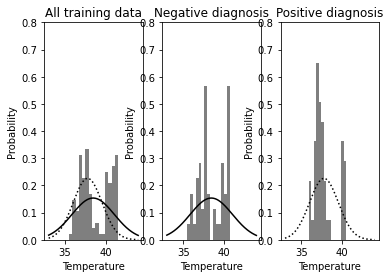

In [82]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(131)
ax.hist(T[:], 15, density = 1, facecolor = 'k', alpha = 0.5)
ax.set_xlabel('Temperature')
ax.set_ylabel('Probability')
Tplot = np.arange(33, 44, 0.05)
ax.plot(Tplot, GausDistribution(Tplot, muApproxTrue, sgApproxTrue), 'k:')
ax.plot(Tplot, GausDistribution(Tplot, muApproxFalse, sgApproxFalse), 'k-')
ax.set_ylim([0,0.8])
ax.set_title("All training data")

ax = fig.add_subplot(132)
ax.hist(T[falseIndex], 15, density = 1, facecolor = 'k', alpha = 0.5)
ax.set_xlabel('Temperature')
ax.set_ylabel('Probability')
ax.plot(Tplot, GausDistribution(Tplot, muApproxFalse, sgApproxFalse), 'k-')
ax.set_ylim([0,0.8])
ax.set_title("Negative diagnosis")

ax = fig.add_subplot(133)
ax.hist(T[trueIndex], 15, density = 1, facecolor = 'k', alpha = 0.5)
ax.set_xlabel('Temperature')
ax.set_ylabel('Probability')
ax.plot(Tplot, GausDistribution(Tplot, muApproxTrue, sgApproxTrue), 'k:')
ax.set_ylim([0,0.8])
ax.set_title("Positive diagnosis")
plt.show()

In [88]:
TTest = T[iTesting]

naiveBayesNominal = NaiveBayesNominal(XTraining, YTraining, dataRecords)

def testNaiveBayesMixed(muTrue, sigmaTrue, muFalse, sigmaFalse):
    correct = np.zeros(2)
    incorrect = np.zeros(2)
        
    for i in range(XTesting.shape[0]):
        pred_class = naiveBayesNominal.predictNaiveBayesMixed(XTesting[i, :].astype(int), TTest[i], muTrue, muFalse, sigmaTrue, sigmaFalse)
        if pred_class == YTesting[i]:
            correct[pred_class] = correct[pred_class] + 1
        else:
            incorrect[pred_class] = incorrect[pred_class] + 1
    return (correct, incorrect)

(correct, incorrect) = testNaiveBayesMixed(muApproxTrue, sgApproxTrue, muApproxFalse, sgApproxFalse)
correct_cases = sum(correct)
total_cases = XTesting.shape[0]
wrong_cases = sum(incorrect)

print("%d cases out of %d cases are correctly classified, %d cases are wrong classified" % (correct_cases, total_cases, wrong_cases))

24 cases out of 24 cases are correctly classified, 0 cases are wrong classified
